In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten
from keras.models import Sequential, Input
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import numpy as np
from numpy.random import uniform, randint, choice
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

In [4]:
def data():

    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('data2/train', 
                                                                           target_size=(224, 224), 
                                                                           batch_size=10, 
                                                                           classes=['pos','neg'])
    validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('data2/validation', 
                                                                           target_size=(224, 224), 
                                                                           batch_size=10, 
                                                                           classes=['pos','neg'])
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('data2/test', 
                                                                           target_size=(224, 224), 
                                                                           batch_size=10, 
                                                                           classes=['pos','neg'])
    return train_generator, validation_generator, test_generator
train_generator, validation_generator, test_generator = data()

Found 117954 images belonging to 2 classes.
Found 14745 images belonging to 2 classes.
Found 14745 images belonging to 2 classes.


In [8]:
next(train_generator)[0].shape

(10, 224, 224, 3)

In [9]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, class_map=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    if class_map:
        class_map_inv = {v: k for k, v in class_map.iteritems()}
        titles = titles.argmax(axis=1)
        titles = [class_map_inv[i] for i in titles]
        
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [10]:
class_map = train_generator.class_indices

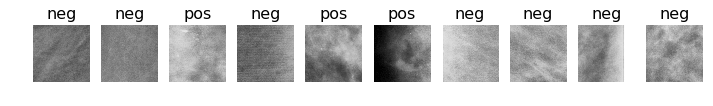

In [11]:
imgs, labels = next(train_generator)
plots(imgs*255, titles=labels, class_map=class_map)

In [15]:
from numpy.random import uniform, randint, choice

base_model = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)

def create_model(base_model):
#     histories = {}

    dense_layers= randint(1,4)
    dense_size = randint(100,1500)
    batch_norm = choice([True, False])
    dropout_rate = uniform(0,.8)
    batch_size = randint(10,120)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)    

    x = Dropout(dropout_rate)(x)
    # let's add a fully-connected layer
    for layer in range(dense_layers):
        if batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(dense_size, activation='relu')(x)

    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    params = {'dense_layers':dense_layers,
              'dense_size':dense_size,
              'batch_norm':batch_norm,
              'dropout_rate':dropout_rate,
              'batch_size':batch_size}
    
    return model, params

create_model(base_model)

(<keras.engine.training.Model at 0x7f44abb90810>,
 {'batch_norm': False,
  'batch_size': 102,
  'dense_layers': 2,
  'dense_size': 265,
  'dropout_rate': 0.25058511922404575})

In [16]:
import time

def iter_models(n_iter, base_model, train_generator, validation_generator):
    base_model = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
    
    histories = {}
    best_model = None
    best_params = None
    best_score = None
    
    counter = Counter(train_generator.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
    
    for i in range(n_iter):
        #TODO: run model multiple times - then average the accuracies
        
        model, params = create_model(base_model)
        print('model_'+str(i), params)
        
        train_generator.batch_size = params['batch_size']
        validation_generator.batch_size = params['batch_size']
        
        t1 = time.time()
        h = model.fit_generator(train_generator, 
#                                 validation_data=validation_generator,
#                                 validation_steps = 50//params['batch_size'],
                                steps_per_epoch=500//params['batch_size'], 
                                class_weight=class_weights, 
                                epochs=100,
                                verbose=1)
        
        score, acc = model.evaluate_generator(validation_generator,2000//params['batch_size'])
        t2 = time.time()
        if acc > best_score or best_score is None:
            best_model = model
            best_params = params
            best_score = acc
        histories['model'+str(i)] = {'history':h,
                                    'params':params,
                                    'score':acc,
                                    'time':t2-t1}
    return histories, best_model, best_params, best_score
                
histories, best_model, best_params, best_score = iter_models(3, base_model, train_generator, validation_generator)
    

('model_0', {'batch_size': 77, 'dropout_rate': 0.044686453866944476, 'dense_size': 1104, 'dense_layers': 3, 'batch_norm': False})
Epoch 1/100
6/6 [==============================] - 37s 6s/step - loss: 1.2597 - acc: 0.3074
Epoch 2/100
6/6 [==============================] - 34s 6s/step - loss: 1.1733 - acc: 0.1732
Epoch 3/100
5/6 [========================>.....] - ETA: 5s - loss: 1.0605 - acc: 0.1325 

KeyboardInterrupt: 

In [ ]:
print(best_params, best_score)

In [ ]:
for history in histories.values():
    plt.plot(history['history'].history['acc'])

In [ ]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

for h in histories:
    pp.pprint(histories[h])

In [196]:
base_model = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} 

dense_layers= 2
dense_size = 500
batch_norm = True
dropout_rate = .25
batch_size = 25

x = base_model.output
x = GlobalAveragePooling2D()(x)    

x = Dropout(dropout_rate)(x)
# let's add a fully-connected layer
for layer in range(dense_layers):
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_size, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

params = {'dense_layers':dense_layers,
          'dense_size':dense_size,
          'batch_norm':batch_norm,
          'dropout_rate':dropout_rate,
          'batch_size':batch_size}



In [234]:
h = model.fit_generator(train_generator, 
                        validation_data=validation_generator,
                        validation_steps = 100//params['batch_size'],
                        steps_per_epoch=1000//params['batch_size'], 
                        class_weight={0: 5.65, 1: 1.0}, 
                        epochs=1,#,17954//(5000//params['batch_size']),
                        verbose=1)

Epoch 1/1
40/40 [==============================] - 234s 6s/step - loss: 1.0762 - acc: 0.6055 - val_loss: 0.6692 - val_acc: 0.4950


In [235]:
validation_generator.batch_size = 50
data, labels = next(validation_generator)

In [236]:
pred = np.argmax(model.predict(data),axis=1)
pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0])

In [237]:
labels = np.argmax(labels, axis=1)
labels

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0])

In [238]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, pred)
# true positives, false negatives
# false positives, true negatives

array([[ 3,  3],
       [24, 20]])

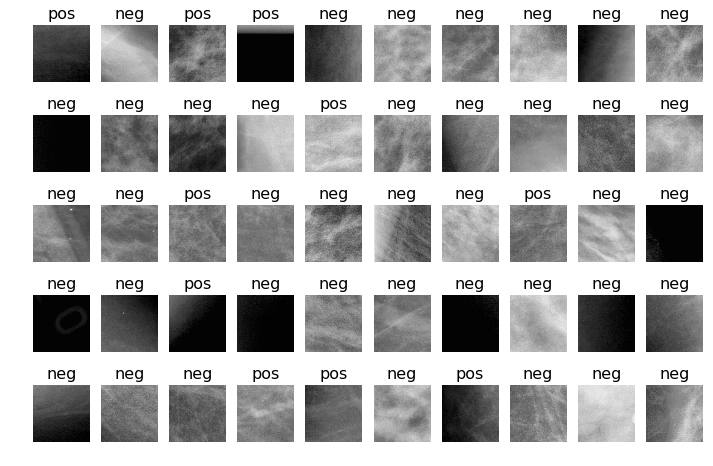

In [239]:
imgs, labels = next(train_generator)
plots(data*255, titles=labels, rows=5, class_map=class_map, figsize=(12,8))

In [203]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [109]:
train_generator.class_indices

{'neg': 1, 'pos': 0}

In [65]:
model.save('1_epoch.h5')